In [78]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet101

from tensorflow.keras import layers, Model



In [79]:
working_path = "D:/Semester 5/MachineORDeep Learning/Final Project"
# file_names = ['encoded-dogcat-img-16.csv', 'encoded-dogcat-img-32.csv', 'encoded-dogcat-img-64.csv', 'encoded-dogcat-img-128.csv']
file_names = ['encoded-dogcat-img-32.csv']

lda = LinearDiscriminantAnalysis()

In [80]:
def model_def(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(50, input_shape=(input_shape,), activation='relu'),  # Layer input dengan 50 neuron
        tf.keras.layers.Dense(50, activation='relu'),  
        tf.keras.layers.Dense(4, activation='softmax') 
    ])
    return model

def model_dropout1(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(50, input_shape=(input_shape,), activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    return model

def residual_block(input_tensor, filters):
    x = tf.keras.layers.Dense(filters, activation='relu')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dense(filters, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # Shortcut connection
    shortcut = tf.keras.layers.Dense(filters)(input_tensor)
    shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    # Tambahkan shortcut ke output
    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def resnet_tabular(input_shape):

    # Membuat model ResNet untuk data Iris
    input_shape = input_shape

    inputs = tf.keras.layers.Input(shape=(input_shape,))
    x = tf.keras.layers.Reshape((input_shape, 1))(inputs)  # Menambahkan dimensi untuk keperluan Conv1D

    x = residual_block(x, 64)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(4, activation='softmax')(x)  # Output layer dengan 3 kelas (Iris memiliki 3 kelas)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

In [81]:
callbacks = [
    # Early stopping untuk menghentikan pelatihan jika tidak ada peningkatan dalam validasi setelah beberapa epoch
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    
    # ModelCheckpoint untuk menyimpan model dengan akurasi validasi terbaik
    ModelCheckpoint('best_model_wo_zeropad.h5', monitor='val_accuracy', save_best_only=True)
]

In [82]:
models = []
accuracies = []
histories = []

for i, f in enumerate(file_names):
    print(f"==> Start Model {file_names[i]} <==")
    df = pd.read_csv(f'{working_path}/dataset/dogcat-encode/{f}')
    df = df.iloc[:,1:]
    # print(df.shape)
    df = df.loc[:, (df != 0).any(axis=0)]  # Mengambil kolom-kolom yang memiliki nilai selain 0
    # print(df.shape)

    X = df.iloc[:,:-1]
    y = df.iloc[:,-1:]

    print(X.shape)
    X_lda = lda.fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.2, random_state=42)
    print(X_train.shape[1])
    # Inisialisasi model sequential
    # model = model_dropout1(X_train.shape[1])
    model = resnet_tabular(X_train.shape[1])

    # Compile model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Latih model
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)
    models.append(model)
    histories.append(history)

    last_accuracy = history.history['val_accuracy'][-1]  # Mengambil akurasi validasi terakhir
    accuracies.append(last_accuracy)

    print(f"==> End Model {file_names[i]} <==")

==> Start Model encoded-dogcat-img-32.csv <==


(807, 900)


c:\ProgramData\anaconda3\envs\mdl\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


3
Epoch 1/50
21/21 [==============================] - 4s 50ms/step - loss: 0.5644 - accuracy: 0.8186 - val_loss: 0.4362 - val_accuracy: 0.9815
Epoch 2/50
21/21 [==============================] - 0s 10ms/step - loss: 0.0870 - accuracy: 0.9969 - val_loss: 0.2468 - val_accuracy: 1.0000
Epoch 3/50
21/21 [==============================] - 0s 8ms/step - loss: 0.0355 - accuracy: 1.0000 - val_loss: 0.1768 - val_accuracy: 1.0000
Epoch 4/50
21/21 [==============================] - 0s 6ms/step - loss: 0.0226 - accuracy: 1.0000 - val_loss: 0.1488 - val_accuracy: 1.0000
Epoch 5/50
21/21 [==============================] - 0s 7ms/step - loss: 0.0147 - accuracy: 1.0000 - val_loss: 0.1287 - val_accuracy: 1.0000
Epoch 6/50
21/21 [==============================] - 0s 6ms/step - loss: 0.0136 - accuracy: 1.0000 - val_loss: 0.1112 - val_accuracy: 1.0000
Epoch 7/50
21/21 [==============================] - 0s 8ms/step - loss: 0.0116 - accuracy: 1.0000 - val_loss: 0.0956 - val_accuracy: 1.0000
Epoch 8/50
21/21

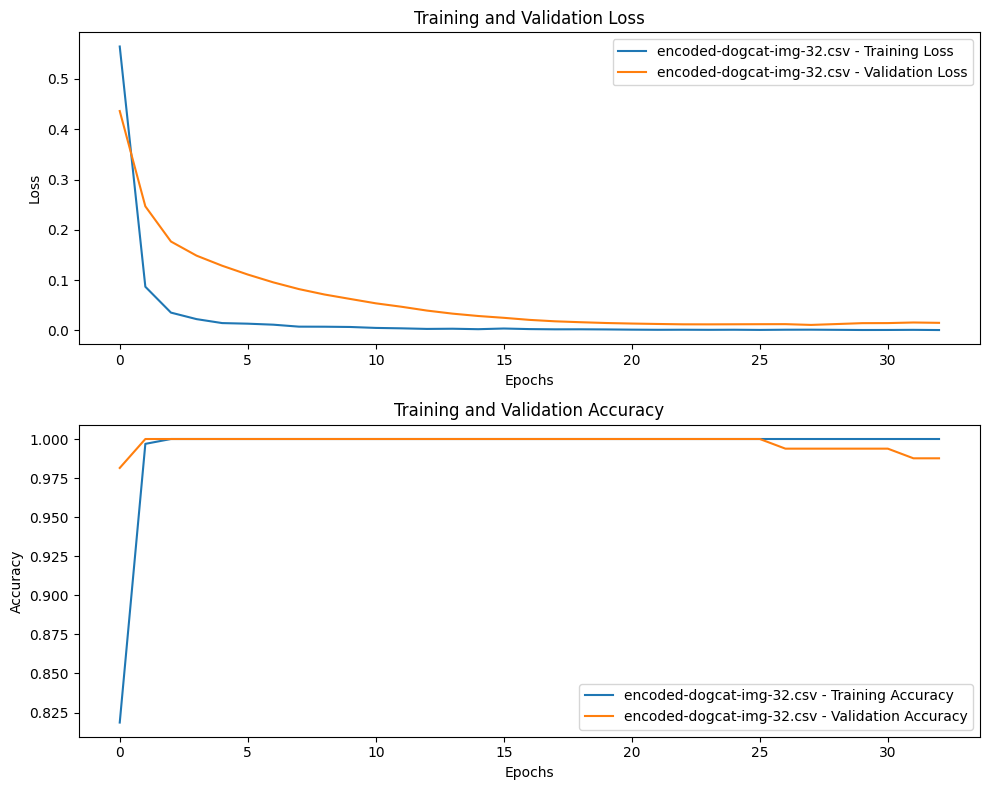

In [85]:
# Plot loss
plt.figure(figsize=(10, 8))
for i, history in enumerate(histories):
    plt.subplot(2, 1, 1)  # Dua baris, satu kolom, plot pertama
    plt.plot(history.history['loss'], label=f'{file_names[i]} - Training Loss')
    plt.plot(history.history['val_loss'], label=f'{file_names[i]} - Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

# Plot akurasi
for i, history in enumerate(histories):
    plt.subplot(2, 1, 2)  # Dua baris, satu kolom, plot kedua
    plt.plot(history.history['accuracy'], label=f'{file_names[i]} - Training Accuracy')
    plt.plot(history.history['val_accuracy'], label=f'{file_names[i]} - Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

In [87]:
res_nn_model = pd.DataFrame({
    'dataset_source': file_names,
    'accuracy' : accuracies
})

res_nn_model.head()

,dataset_source,accuracy
0,encoded-dogcat-img-32.csv,0.987654
